<a href="https://colab.research.google.com/github/one-2730/Generative-Model/blob/main/GM_study_week2_ch4_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CHAPTER 4 가우스 혼합 모델

##4.1 우리 주변의 다봉 분포

- 남녀 혼합 키 분포
- 개미 몸 길이
- 간헐천 분출

### 4.1.1 다봉 분포 데이터셋

In [1]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.loadtxt('old_faithful.txt')

print(xs.shape)
print(xs[0])

(272, 2)
[ 3.6 79. ]


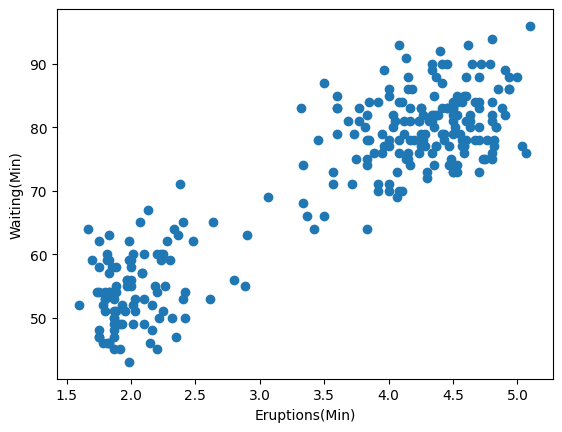

In [2]:
plt.scatter(xs[:, 0], xs[:, 1])
plt.xlabel('Eruptions(Min)')
plt.ylabel('Waiting(Min)')
plt.show()

##4.2 가우스 혼합 모델 데이터 생성

1. 모델링: 관측 데이터의 분포를 GMM으로 표현할 수 있다고 가정
2. 매개변수 추정: GMM의 매개변수를 추정
-> MLE로 추정하기 어려워서 EM에 의존

###4.2.1 GMM을 따르는 데이터 생성

두 개의 정규 분포를 준비한다.<br>
반복:
  1. 임의의 확률 분포에 따라 두 정규 분포 중 하나를 선택
  2. 선택한 정규 분포에서 데이터를 생성

###4.2.2 데이터 생성 코드

In [3]:
mus = np.array([[2.0, 54.51],
                [4.3, 80.0]])
covs = np.array([[[0.07, 0.44],
                  [0.44, 33.7]],
                  [[0.17, 0.94],
                  [0.94, 36.00]]])
phis = np.array([0.35, 0.65])

def sample():
  z = np.random.choice(2, p=phis)
  mu, cov = mus[z], covs[z]
  x = np.random.multivariate_normal(mu, cov)
  return x

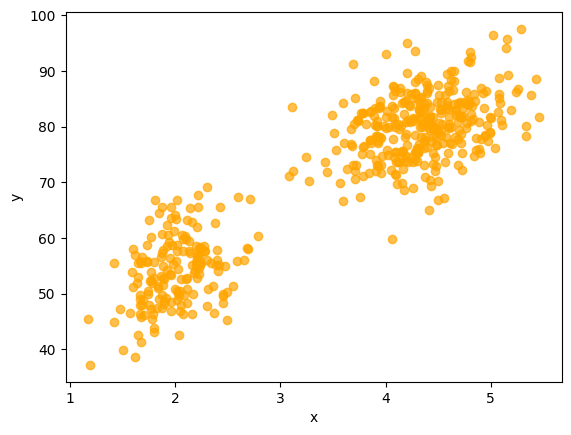

In [4]:
N = 500
xs = np.zeros((N, 2))
for i in range(N):
  xs[i] = sample()

plt.scatter(xs[:, 0], xs[:, 1], color='orange', alpha=0.7)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

##4.3 가우스 혼합 모델의 수식

###4.3.1 확률 복습

- 결합 확률: $p(x, y)$
- 주변 확률: $p(x), p(y)$
- 조건부 확률: $p(x|y)$

###4.3.2 GMM 수식

두 개의 정규 분포를 준비한다.<br>
반복:
  1. 임의의 확률 분포에 따라 두 정규 분포 중 하나를 선택
  2. 선택한 정규 분포에서 데이터를 생성

위에서 1번 과정을 **범주형 분포**로 표현
<br>  $p(z = k|\Phi) = \Phi k$

GMM 표현
<br> $p(x) = \sum^{K}_{k=1} \Phi _{k} N(x|\mu _{k}, \Sigma _{k})$

###4.3.3 GMM 구현

In [5]:
mus = np.array([[2.0, 54.51],
                [4.3, 80.0]])
covs = np.array([[[0.07, 0.44],
                  [0.44, 33.7]],
                  [[0.17, 0.94],
                  [0.94, 36.00]]])
phis = np.array([0.35, 0.65])

def multivariate_normal(x, mu, cov):
  det = np.linalg.det(cov)
  inv = np.linalg.inv(cov)
  d = len(x)
  z = 1 / np.sqrt((2*np.pi)**d*det)
  y = z*np.exp((x-mu).T@inv@(x-mu)/-2.0)
  return y

def gmm(x, phis, mus, covs):
  K = len(phis)
  y = 0
  for k in range(K):
    phi, mu, cov = phis[k], mus[k], covs[k]
    y += phi * multivariate_normal(x, mu, cov)
  return y

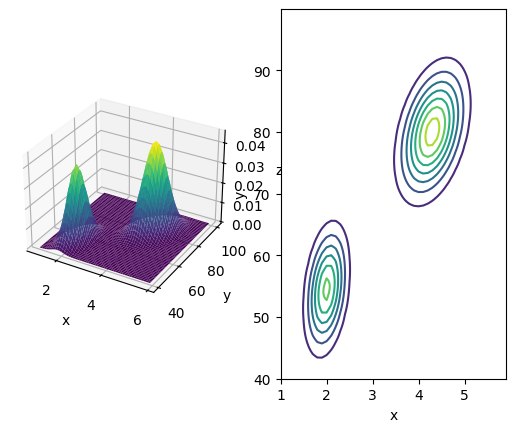

In [6]:
xs = np.arange(1, 6, 0.1)
ys = np.arange(40, 100, 0.1)
X, Y = np.meshgrid(xs, ys)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
  for j in range(X.shape[1]):
    x = np.array([X[i, j], Y[i, j]])
    Z[i, j] = gmm(x, phis, mus, covs)

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.plot_surface(X, Y, Z, cmap='viridis')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.contour(X, Y, Z)
plt.show()

##4.4 매개변수 추정의 어려움

log-likelihood를 최대화하는 매개변수를 구하는 것이 해석적으로 불가능 (log-sum 형태이기 때문)

$l(\theta) = \sum ^{N}_{n=1}ln(\sum ^{K}_{k=1}\Phi _{k}N(x{(n)}|\mu _k\Sigma _k))$
<br>
<br>
-> EM 알고리즘

#CHAPTER 5 EM 알고리즘

EM(Expection Maximization) 기댓값 최대화 알고리즘

##5.1 KL 발산

### 5.1.1 수식 표기법 변경

$E[f(x)]=E_{p(x)}[f(x)]$<br>
$p(x|\theta) = p_\theta (x)$

그렇게 한대용

###5.1.2 KL 발산 정의식

Kullback-Leibler divergence(쿨백-라이블러 발산)

$D_{KL}(p||q) = \int p(x) log \frac {p(x)}{q(x)}dx$
* 이산이면 적분 말고 summation


***
**KL 발산의 특징**
- 두 확률 분포가 다를수록 값이 커진다
- 0 이상의 값을 가지며 두 확률 분포가 같을 때만 0이 된다
- 비대칭 척도이기 때문에 $D_{KL}(p||q)\ne D_{KL}(q||p)$

-> 두 확률 분포가 얼마나 다른지 나타내는 척도로 활용

###5.1.3 KL 발산과 최대 가능도 추정의 관계

$D_{KL}(p_*||p_\theta) = \int p_*(x) log \frac{p_*(x)}{p_\theta(x)} dx$

근데 $p_*(x)$의 수식을 구체적으로 모르니까 걍 몬테카를로 ㄱㄱ
<br> 그러면 아래가 됨. 그래서 KL 발산으로 구하는거랑 MLE랑 같음
<br>
$\underset{\theta}{argmin} D_{KL}(p_*||p_{\theta}) \approx \underset{\theta}{argmax}\sum ^{N}_{n=1}logp_\theta(x_n)$

##5.2 EM 알고리즘 도출 1

**잠재변수가 있는 모델들**
- GMM
- VAE (Variable Auto Encoder)
- HMM (Hidden Markov Model)

###5.2.1 잠재 변수가 있는 모델

log-likelihood의 형태가 복잡함을 앞에서 설명함.
<br>
$p_\theta(z|x)=\frac{p_\theta(x, z)}{\sum_{z}p_\theta(x, z)}$
<br>베이즈 정리를 이용해서 식을 이렇게 변형
그러나 여전히 분모는 로그합 형태.

###5.2.2 임의의 확률 분포 $q(z)$

이 문제를 해결하기 위해 $q_\theta(z|x)$를 아무 분포 $q(z)$로 대체

$logp_\theta(x) = log \frac{p_\theta(x, z)}{q(z)} + log\frac{q(z)}{p_\theta(z|x)}$

$= \underset{z}{\sum}q(z)log \frac{p_\theta(x,z)}{q(z)}+D_{KL}(q(z)||p_\theta(z|x))$

##5.3 EM 알고리즘 도출 2

###5.3.1 ELBO(증거 하한)

어떤 $q(z)$를 사용하더라도 KL 발산은 항상 0 이상.

따라서 $p_\theta(z|x) \ge \underset{z}{\sum}q(z)log \frac{p_\theta(x,z)}{q(z)}$
<br> *옌센 부등식으로도 도출 가능*<br>
<br>
**증거하한(Evidence Lower BOund)**: 로그 가능도의 최솟값을 의미
<br>
$ELBO(x|q, \theta) = \underset{z}{\sum}q(z)log \frac{p_\theta(x,z)}{q(z)}$
<br>
<br>
**ELBO의 특징** <br>
- 로그 가능도의 값은 항상 ELBO 이상이다
- ELBO는 합-로그 형태라서 해석적으로 계산하기 쉽다

### 5.3.2 드디어 EM 알고리즘으로

매개변수 둘 중 하나를 고정하고 나머지를 갱신, 다른 하나를 고정하고 나머지를 갱신... 이런식으로 매개변수 최적화

**E-스텝**: $q(z)$의 갱신
<br>$q(z)=p_{\theta_{old}}(z|x)$

**M-스텝**: $\theta$의 갱신
<br> ELBO 최대화 (해석적으로 계산)

<br>EM 알고리즘에서 로그 가능도는 단조 증가.
1. 더 이상 증가하지 않는 시점까지 갱신
2. 실용적으로는, 로그 가능도 변화량의 절댓값이 임곗값 이하로 떨어지면 갱신 루프 중단


###5.3.3 다수의 데이터로 확장

EM 알고리즘 정리

1. E-스텝: ${(q^{(1)}, q^{(2)}, ..., q^{(N)})}$ 갱신
2. M-스텝: $\theta$ 갱신
3. 종료 판정

##5.4 GMM과 EM 알고리즘

###5.4.1 EM 알고리즘의 E-스텝

$\theta =${$\Phi, \mu, \Sigma$}

E-스텝<br>
$q^{(n)}(k) = \frac{\phi_kN(x^{(n)}|\mu_k, \Sigma_k}{\sum^K_{j=1}\phi_jN(x^{(n)}|\mu_j, \Sigma_j}$

###5.4.2 EM 알고리즘의 M-스텝

M-스텝<br>
$\Phi_k = \frac{1}{N}\sum\limits^{N}_{n=1}q^{(n)}(k)$
<br>$\mu_k = \frac{\sum^{N}_{n=1}q^{(n)}(k)x^{(n)}}{\sum^N_{n=1}q^{(n)}(k)}$
<br>$\Sigma_k = \frac{\sum^N_{n=1}q^{(n)}(k)(x^{(n)}-\mu_k)(x^{(n)}-\mu_k)^\top}{\sum^N_{n=1}q^{(n)}(k)}$

종료판정<br>
$\frac{1}{N}\sum\limits^N_{n=1}log\sum\limits^K_{j=1}\Phi_jN(x^{(n)}|\mu_j, \Sigma_j)$
를 계산하여 이전 로그 가능도와 비교

##5.5 EM 알고리즘 구현

### 5.5.1 데이터셋과 GMM 코드

In [7]:
xs = np.loadtxt('old_faithful.txt')

print(xs.shape)

#초깃값
phis = np.array([0.5, 0.5])
mus = np.array([[0.0, 50.0], [0.0, 100.0]])
covs = np.array([np.eye(2), np.eye(2)])

K = len(phis)
N = len(xs)
MAX_ITERS = 100
THRESHOLD = 1e-4

(272, 2)


In [8]:
def multivariate_normal(x, mu, cov):
  det = np.linalg.det(cov)
  inv = np.linalg.inv(cov)
  d = len(x)
  z = 1 / np.sqrt((2*np.pi)**d*det)
  y = z*np.exp((x-mu).T@inv@(x-mu)/-2.0)
  return y

def gmm(x, phis, mus, covs):
  K = len(phis)
  y = 0
  for k in range(K):
    phi, mu, cov = phis[k], mus[k], covs[k]
    y += phi * multivariate_normal(x, mu, cov)
  return y

def likelihood(xs, phis, mus, covs):
  eps = 1e-8
  L = 0
  N = len(xs)
  for x in xs:
    y = gmm(x, phis, mus, covs)
    L += np.log(y + eps)
  return L/N

### 5.5.2 E-스텝과 M-스텝 구현

In [9]:
current_likelihood = likelihood(xs, phis, mus, covs)

for iter in range(MAX_ITERS):
#E-스텝
  qs = np.zeros((N, K))
  for n in range(N):
    x = xs[n]
    for k in range(K):
      phi, mu, cov = phis[k], mus[k], covs[k]
      qs[n, k] = phi * multivariate_normal(x, mu, cov)
    qs[n] /= gmm(x, phis, mus, covs)

#M-스텝
  qs_sum = qs.sum(axis=0)
  for k in range(K):
    phis[k] = qs_sum[k]/N

    c=0
    for n in range(N):
      c += qs[n, k] * xs[n]
    mus[k] = c / qs_sum[k]

    c=0
    for n in range(N):
      z = xs[n] - mus[k]
      z = z[:, np.newaxis]
      c += qs[n, k] * z @ z.T
    covs[k] = c / qs_sum[k]

#종료 판정
  print(f'{current_likelihood:.3f}')

  next_likelihood = likelihood(xs, phis, mus, covs)
  diff = np.abs(next_likelihood - current_likelihood)
  if diff < THRESHOLD:
    break
  current_likelihood = next_likelihood

-16.538
-4.415
-4.357
-4.302
-4.245
-4.200
-4.164
-4.156
-4.155


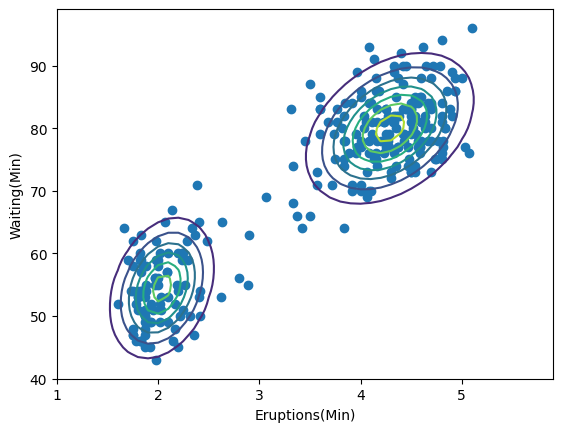

In [10]:
# visualize
def plot_contour(w, mus, covs):
    x = np.arange(1, 6, 0.1)
    y = np.arange(40, 100, 1)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x = np.array([X[i, j], Y[i, j]])

            for k in range(len(mus)):
                mu, cov = mus[k], covs[k]
                Z[i, j] += w[k] * multivariate_normal(x, mu, cov)
    plt.contour(X, Y, Z)

plt.scatter(xs[:,0], xs[:,1])
plot_contour(phis, mus, covs)
plt.xlabel('Eruptions(Min)')
plt.ylabel('Waiting(Min)')
plt.show()

### 5.5.3 데이터 생성

In [11]:
N = 500
new_xs = np.zeros((N, 2))
for n in range(N):
  k = np.random.choice(2, p=phis)
  mu, cov = mus[k], covs[k]
  new_xs[n] = np.random.multivariate_normal(mu, cov)

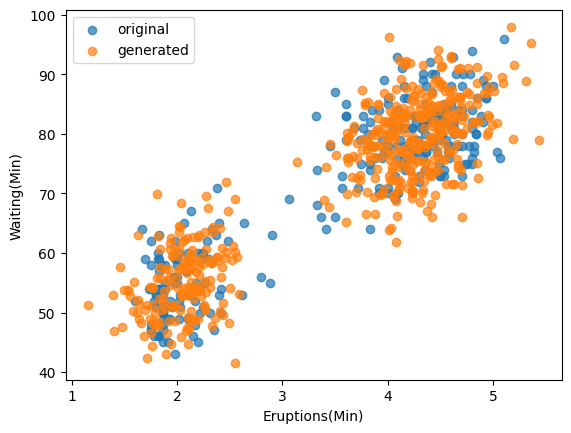

In [12]:
# visualize
original_xs = np.loadtxt('old_faithful.txt')

plt.scatter(original_xs[:,0], original_xs[:,1], alpha=0.7, label='original')
plt.scatter(new_xs[:,0], new_xs[:,1], alpha=0.7, label='generated')
plt.legend()
plt.xlabel('Eruptions(Min)')
plt.ylabel('Waiting(Min)')
plt.show()

#CHAPTER 6 신경망

신경망, 선형회귀는 아니깐... 코드만 복습

##6.1 파이토치와 경사법

###6.1.2 텐서 계산

In [13]:
import torch

x = torch.tensor(5.0, requires_grad=True)
y = 3 * x ** 2
print(y)

y.backward()
print(x.grad)

tensor(75., grad_fn=<MulBackward0>)
tensor(30.)


###6.1.3 경사법

In [14]:
def rosenbrock(x0, x1):
    y = 100 * (x1 - x0 ** 2) ** 2 + (x0 - 1) ** 2
    return y

x0 = torch.tensor(0.0, requires_grad=True)
x1 = torch.tensor(2.0, requires_grad=True)

y = rosenbrock(x0, x1)
y.backward()
print(x0.grad, x1.grad)

lr = 0.001
iters = 10000

for i in range(iters):
    if i % 1000 == 0:
        print(x0.item(), x1.item())

    y = rosenbrock(x0, x1)

    y.backward()

    x0.data -= lr * x0.grad.data
    x1.data -= lr * x1.grad.data

    x0.grad.zero_()
    x1.grad.zero_()

print(x0.item(), x1.item())

tensor(-2.) tensor(400.)
0.0 2.0
0.6815015077590942 0.46292299032211304
0.8253857493400574 0.6804871559143066
0.8942827582359314 0.7992911338806152
0.9331904053688049 0.8705660700798035
0.9568046927452087 0.9152978658676147
0.9716982245445251 0.9440822601318359
0.9813036918640137 0.9628812670707703
0.98758465051651 0.9752733111381531
0.9917276501655579 0.983490526676178
0.9944759607315063 0.9889602065086365


##6.2 선형 회귀

###6.2.1 토이 데이터셋

In [15]:
torch.manual_seed(0)
x = torch.rand(100, 1)
y = 5 + 2 * x + torch.rand(100, 1)

###6.2.3 선형 회귀 구현

In [16]:
torch.manual_seed(0)
x = torch.rand(100, 1)
y = 5 + 2 * x + torch.rand(100, 1)

W = torch.zeros((1, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

def predict(x):
    y = x @ W + b
    return y

def mean_squared_error(x0, x1):
    diff = x0 - x1
    N = len(diff)
    return torch.sum(diff ** 2) / N

lr = 0.1
iters = 100

for i in range(iters):
    y_hat = predict(x)
    loss = mean_squared_error(y, y_hat)

    loss.backward()

    W.data -= lr * W.grad.data
    b.data -= lr * b.grad.data

    W.grad.zero_()
    b.grad.zero_()

    if i % 10 == 0: # print every 10 iterations
        print(loss.item())

print(loss.item())
print('====')
print('W =', W.item())
print('b =', b.item())

41.89796447753906
0.22483211755752563
0.0925208106637001
0.0888015553355217
0.08627457916736603
0.08435674756765366
0.0829005315899849
0.0817948430776596
0.08095530420541763
0.08031783998012543
0.07987643033266068
====
W = 2.2863590717315674
b = 5.3144850730896


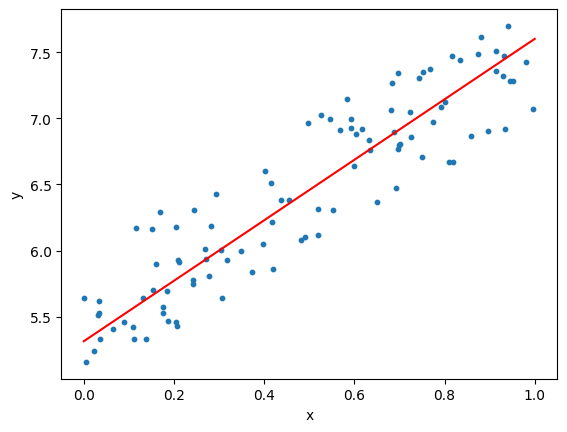

In [17]:
# plot
import matplotlib.pyplot as plt
plt.scatter(x.detach().numpy(), y.detach().numpy(), s=10)
x = torch.tensor([[0.0], [1.0]])
y = W.detach().numpy() * x.detach().numpy() + b.detach().numpy()
plt.plot(x, y, color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

##6.3 매개변수와 옵티마이저

###6.3.1 Parameter 클래스와 Module 클래스

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

W = nn.Parameter(torch.zeros(1, 1))
b = nn.Parameter(torch.zeros(1))

print(W)
print(b)

Parameter containing:
tensor([[0.]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


In [19]:
class Model(nn.Module):
    def __init__(self, input_size=1, hidden_size= 10, output_size=1):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
      y = self.linear(x)
      return y

model = Model()

for param in model.parameters():
  print(param)

Parameter containing:
tensor([[0.0421]], requires_grad=True)
Parameter containing:
tensor([0.6446], requires_grad=True)


###6.3.2 옵티마이저

In [20]:
x = torch.rand(100, 1)
y = 5+ 2* x + torch.rand(100, 1)

lr = 0.1
iters = 100

model = Model()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for i in range(iters):
  y_hat = model(x)
  loss = nn.functional.mse_loss(y, y_hat)

  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

##6.4 신경망 구현

###6.4.1 비선형 데이터셋

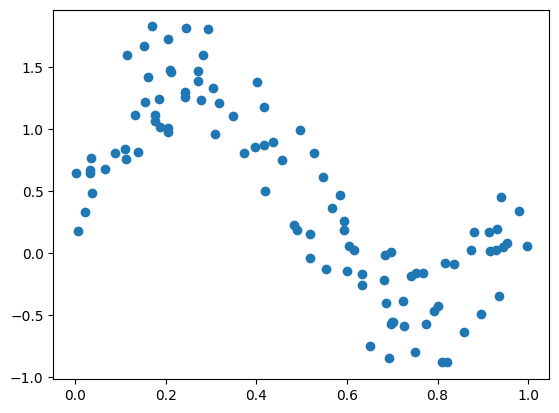

In [21]:
torch.manual_seed(0)
x = torch.rand(100, 1)
y = torch.sin(2 * torch.pi * x) + torch.rand(100, 1)

plt.scatter(x, y)
plt.show()

###6.4.2 선형 변환과 활성화 함수

In [22]:
a = torch.rand(100, 5)

b = F.sigmoid(a)
c = F.relu(a)

###6.4.3 신경망 구현

In [23]:
class Model(nn.Module):
    def __init__(self, input_size=1, hidden_size= 10, output_size=1):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        y = self.linear1(x)
        y = F.sigmoid(y)
        y = self.linear2(y)
        return y

In [24]:
lr = 0.2
iters = 10000

model = Model()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for i in range(iters):
    y_pred = model(x)
    loss = F.mse_loss(y, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 1000 == 0:
        print(loss.item())

print(loss.item())

0.9632322788238525
0.23952196538448334
0.23782415688037872
0.23403015732765198
0.22124022245407104
0.1850355565547943
0.11827993392944336
0.08544430136680603
0.08229503035545349
0.08174017071723938
0.0814223363995552


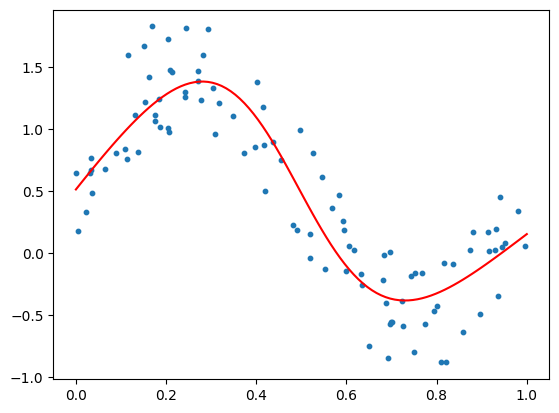

In [25]:
# plot
import matplotlib.pyplot as plt
plt.scatter(x.detach().numpy(), y.detach().numpy(), s=10)
x = torch.linspace(0, 1, 100).reshape(-1, 1)
y = model(x).detach().numpy()
plt.plot(x, y, color='red')
plt.show()

##6.5 토치비전과 데이터셋

size: 60000
type: <class 'PIL.Image.Image'>
label: 5


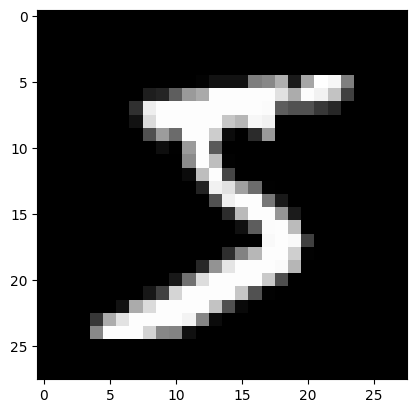

type: <class 'torch.Tensor'>
shape: torch.Size([1, 28, 28])
x shape: torch.Size([32, 1, 28, 28])
label shape: torch.Size([32])


In [26]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=None,
    download=True
)

x, label = dataset[0]

print('size:', len(dataset))
print('type:', type(x))
print('label:', label)

plt.imshow(x, cmap='gray')
plt.show()

transform = transforms.ToTensor()

dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

x, label = dataset[0]
print('type:', type(x))
print('shape:', x.shape)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=32,
    shuffle=True)

for x, label in dataloader:
    print('x shape:', x.shape)
    print('label shape:', label.shape)
    break